In [1]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..") 

from src.utils import *
from src.plots import *
from src.late_fusion import *

# Late fusion

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
audio_embs = torch.load('../embeddings/audio/raw_wavlm.pt')
video_embs = torch.load('../embeddings/video/raw.pt')

In [3]:
train_loader_audio, test_loader_audio = train_test_dataloader(audio_embs)

model_audio = MLP(input_dim = 1024, hidden_dims = [512], output_dim = 6).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer_audio = optim.Adam(model_audio.parameters(), lr = 0.001)
num_epochs = 50


####################################################################################################


train_loader_video, test_loader_video = train_test_dataloader(video_embs)

model_video = MLP(input_dim = 512, hidden_dims = [256], output_dim = 6).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer_video = optim.Adam(model_video.parameters(), lr = 0.001)
num_epochs = 50


####################################################################################################


PARAMS = {'models': [model_audio, model_video],
        'optimizers': [optimizer_audio, optimizer_video],
        'train_loaders': [train_loader_audio, train_loader_video],
        'test_loaders': [test_loader_audio, test_loader_video],
        'criterion': criterion,
        'num_epochs': num_epochs,
        'device': DEVICE}

/home/mweuro/venvy/best_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
epochs, losses, accs, precs, recs, best_epoch, best_cm = train_late_fusion(**PARAMS)

Epoch 5/50
Val Loss Audio: 0.7990,                    Val Accuracy Audio: 0.7173,                    Val Precision Audio: 0.7285,                    Val Recall Audio: 0.7173.
Val Loss Video: 1.2769,                    Val Accuracy Video: 0.4896,                    Val Precision Video: 0.4696,                    Val Recall Video: 0.4896.
Fusion Loss: 1.5711,                    Fusion Accuracy: 0.5292,                    Fusion Precision: 0.5188,                    Fusion Recall: 0.5292.
--------------------------------------------------


Epoch 10/50
Val Loss Audio: 0.7138,                    Val Accuracy Audio: 0.7408,                    Val Precision Audio: 0.7511,                    Val Recall Audio: 0.7408.
Val Loss Video: 1.1054,                    Val Accuracy Video: 0.5601,                    Val Precision Video: 0.5641,                    Val Recall Video: 0.5601.
Fusion Loss: 1.5102,                    Fusion Accuracy: 0.5897,                    Fusion Precision: 0.5856,                    Fusion Recall: 0.5897.
--------------------------------------------------


Epoch 15/50
Val Loss Audio: 0.6988,                    Val Accuracy Audio: 0.7623,                    Val Precision Audio: 0.7711,                    Val Recall Audio: 0.7623.
Val Loss Video: 1.0752,                    Val Accuracy Video: 0.5876,                    Val Precision Video: 0.5997,                    Val Recall Video: 0.5876.
Fusion Loss: 1.4936,                    Fusion Accuracy: 0.6192,                    Fusion Precision: 0.6132,                    Fusion Recall: 0.6192.
--------------------------------------------------


Epoch 20/50
Val Loss Audio: 0.6759,                    Val Accuracy Audio: 0.7542,                    Val Precision Audio: 0.7603,                    Val Recall Audio: 0.7542.
Val Loss Video: 1.0098,                    Val Accuracy Video: 0.6212,                    Val Precision Video: 0.6381,                    Val Recall Video: 0.6212.
Fusion Loss: 1.4596,                    Fusion Accuracy: 0.6561,                    Fusion Precision: 0.6551,                    Fusion Recall: 0.6561.
--------------------------------------------------


Epoch 25/50
Val Loss Audio: 0.7089,                    Val Accuracy Audio: 0.7589,                    Val Precision Audio: 0.7623,                    Val Recall Audio: 0.7589.
Val Loss Video: 0.9705,                    Val Accuracy Video: 0.6091,                    Val Precision Video: 0.6252,                    Val Recall Video: 0.6091.
Fusion Loss: 1.4562,                    Fusion Accuracy: 0.6521,                    Fusion Precision: 0.6525,                    Fusion Recall: 0.6521.
--------------------------------------------------


Epoch 30/50
Val Loss Audio: 0.8003,                    Val Accuracy Audio: 0.7455,                    Val Precision Audio: 0.7577,                    Val Recall Audio: 0.7455.
Val Loss Video: 0.9530,                    Val Accuracy Video: 0.6246,                    Val Precision Video: 0.6270,                    Val Recall Video: 0.6246.
Fusion Loss: 1.4439,                    Fusion Accuracy: 0.6555,                    Fusion Precision: 0.6574,                    Fusion Recall: 0.6555.
--------------------------------------------------


Epoch 35/50
Val Loss Audio: 0.7907,                    Val Accuracy Audio: 0.7448,                    Val Precision Audio: 0.7488,                    Val Recall Audio: 0.7448.
Val Loss Video: 0.9370,                    Val Accuracy Video: 0.6333,                    Val Precision Video: 0.6298,                    Val Recall Video: 0.6333.
Fusion Loss: 1.4391,                    Fusion Accuracy: 0.6622,                    Fusion Precision: 0.6634,                    Fusion Recall: 0.6622.
--------------------------------------------------


Epoch 40/50
Val Loss Audio: 0.7824,                    Val Accuracy Audio: 0.7629,                    Val Precision Audio: 0.7663,                    Val Recall Audio: 0.7629.
Val Loss Video: 1.0544,                    Val Accuracy Video: 0.5803,                    Val Precision Video: 0.6782,                    Val Recall Video: 0.5803.
Fusion Loss: 1.4275,                    Fusion Accuracy: 0.6756,                    Fusion Precision: 0.6790,                    Fusion Recall: 0.6756.
--------------------------------------------------


Epoch 45/50
Val Loss Audio: 0.8727,                    Val Accuracy Audio: 0.7515,                    Val Precision Audio: 0.7564,                    Val Recall Audio: 0.7515.
Val Loss Video: 0.9284,                    Val Accuracy Video: 0.6246,                    Val Precision Video: 0.6638,                    Val Recall Video: 0.6246.
Fusion Loss: 1.4282,                    Fusion Accuracy: 0.6749,                    Fusion Precision: 0.6764,                    Fusion Recall: 0.6749.
--------------------------------------------------


Epoch 50/50
Val Loss Audio: 0.8800,                    Val Accuracy Audio: 0.7562,                    Val Precision Audio: 0.7575,                    Val Recall Audio: 0.7562.
Val Loss Video: 0.9191,                    Val Accuracy Video: 0.6394,                    Val Precision Video: 0.6886,                    Val Recall Video: 0.6394.
Fusion Loss: 1.4127,                    Fusion Accuracy: 0.6931,                    Fusion Precision: 0.6966,                    Fusion Recall: 0.6931.
--------------------------------------------------
BEST EPOCH: 48.00          BEST LOSS: 1.42          BEST ACCURACY: 0.68          BEST PRECISION: 0.69          BEST RECALL: 0.68


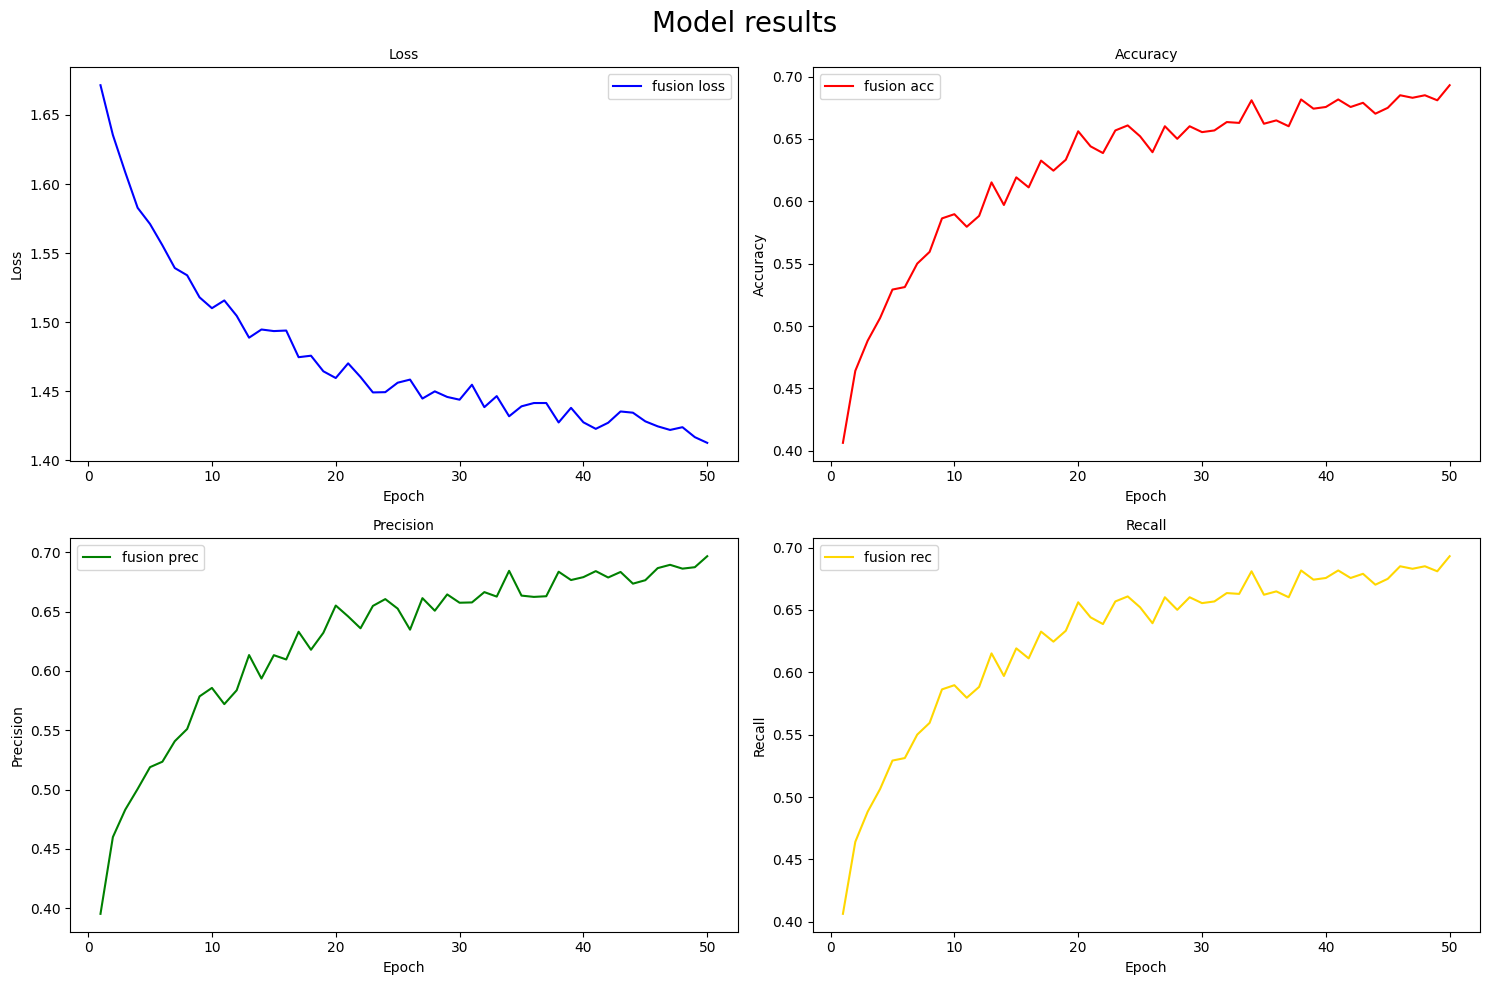

In [5]:
plot_metrics_late_fusion(losses, accs, precs, recs)

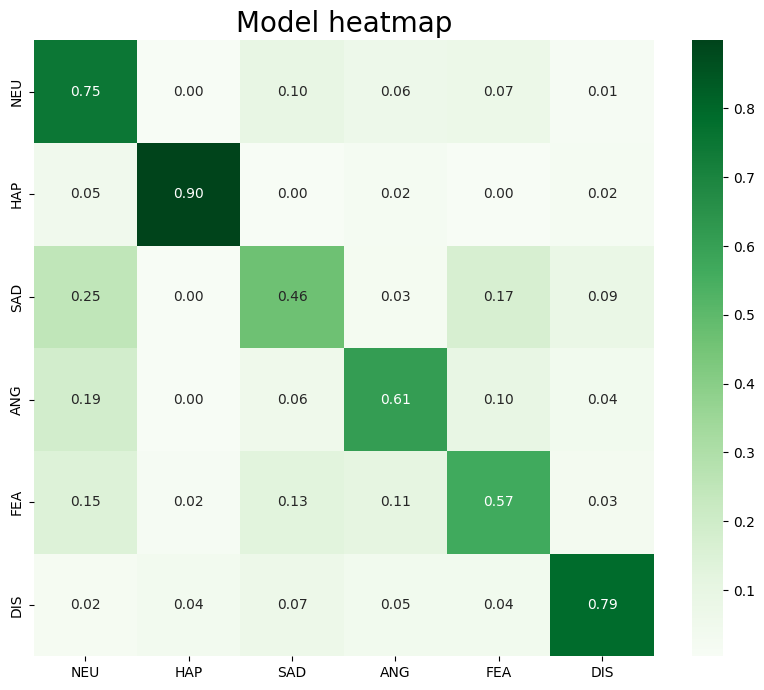

In [6]:
plot_confusion_matrix(best_cm)